In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install transformers torch pandas scikit-learn accelerate>=0.26.0

In [3]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [4]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer

In [5]:
# Load dataset dan model dari drive
GDRIVE_PROJECT_PATH = '/content/drive/MyDrive/ril-or-fek/'
DATASET_PATH = os.path.join(GDRIVE_PROJECT_PATH, 'dataset_final.csv')
INDOBERT_MODEL_PATH = os.path.join(GDRIVE_PROJECT_PATH, 'model_final_indobert')

print(f"1. Memuat dataset dari: {DATASET_PATH}")
df = pd.read_csv(DATASET_PATH)
df.dropna(subset=['Clean Narasi', 'hoax'], inplace=True)
df['hoax'] = df['hoax'].astype(int)

X = df['Clean Narasi']
y = df['hoax']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Data uji siap. Total {len(X_test)} artikel untuk diuji.")

1. Memuat dataset dari: /content/drive/MyDrive/ril-or-fek/dataset_final.csv
Data uji siap. Total 4919 artikel untuk diuji.


In [6]:
# Train ulang baseline model
print("\n2. Melatih ulang Baseline Model...")
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
baseline_model = MultinomialNB()
baseline_model.fit(X_train_tfidf, y_train)
print("Baseline model siap.")

# Load advanced model dari drive
print(f"\n3. Memuat Advanced Model (IndoBERT) dari: {INDOBERT_MODEL_PATH}")
tokenizer = AutoTokenizer.from_pretrained(INDOBERT_MODEL_PATH)
advanced_model = AutoModelForSequenceClassification.from_pretrained(INDOBERT_MODEL_PATH)
print("Advanced model siap.")


2. Melatih ulang Baseline Model...
Baseline model siap.

3. Memuat Advanced Model (IndoBERT) dari: /content/drive/MyDrive/ril-or-fek/model_final_indobert
Advanced model siap.


In [7]:
# Evaluasi baseline model
print("\n--- Mengevaluasi BASELINE MODEL ---")
X_test_tfidf = tfidf_vectorizer.transform(X_test)
y_pred_baseline = baseline_model.predict(X_test_tfidf)
accuracy_baseline = accuracy_score(y_test, y_pred_baseline)
print(f"Akurasi Baseline Model: {accuracy_baseline * 100:.2f}%")

# Evaluasi advanced model
print("\n--- Mengevaluasi ADVANCED MODEL (INDOBERT) ---")
test_encodings = tokenizer(X_test.tolist(), truncation=True, padding=True, max_length=512)

class HoaxDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.labels)

test_dataset = HoaxDataset(test_encodings, y_test.tolist())
trainer = Trainer(model=advanced_model)
predictions = trainer.predict(test_dataset)
y_pred_advanced = np.argmax(predictions.predictions, axis=-1)
accuracy_advanced = accuracy_score(y_test, y_pred_advanced)
print(f"Akurasi Advanced Model: {accuracy_advanced * 100:.2f}%")


--- Mengevaluasi BASELINE MODEL ---
Akurasi Baseline Model: 95.65%

--- Mengevaluasi ADVANCED MODEL (INDOBERT) ---


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Akurasi Advanced Model: 99.84%


In [8]:
# Perbandingan antara baseline model dan advanced model
print("\n==============================================")
print("     PERBANDINGAN PERFORMA MODEL")
print("==============================================")

metrics_summary = {
    "Metrik": ["Akurasi", "Presisi (Hoaks)", "Recall (Hoaks)", "F1-Score (Hoaks)"],
    "Baseline (Naive Bayes)": [
        accuracy_score(y_test, y_pred_baseline),
        classification_report(y_test, y_pred_baseline, output_dict=True)['1']['precision'],
        classification_report(y_test, y_pred_baseline, output_dict=True)['1']['recall'],
        classification_report(y_test, y_pred_baseline, output_dict=True)['1']['f1-score']
    ],
    "Advanced (IndoBERT)": [
        accuracy_score(y_test, y_pred_advanced),
        classification_report(y_test, y_pred_advanced, output_dict=True)['1']['precision'],
        classification_report(y_test, y_pred_advanced, output_dict=True)['1']['recall'],
        classification_report(y_test, y_pred_advanced, output_dict=True)['1']['f1-score']
    ]
}
comparison_df = pd.DataFrame(metrics_summary)
print(comparison_df.to_markdown(index=False))


     PERBANDINGAN PERFORMA MODEL
| Metrik           |   Baseline (Naive Bayes) |   Advanced (IndoBERT) |
|:-----------------|-------------------------:|----------------------:|
| Akurasi          |                 0.956495 |              0.998374 |
| Presisi (Hoaks)  |                 0.988769 |              0.997494 |
| Recall (Hoaks)   |                 0.920921 |              0.999163 |
| F1-Score (Hoaks) |                 0.95364  |              0.998328 |


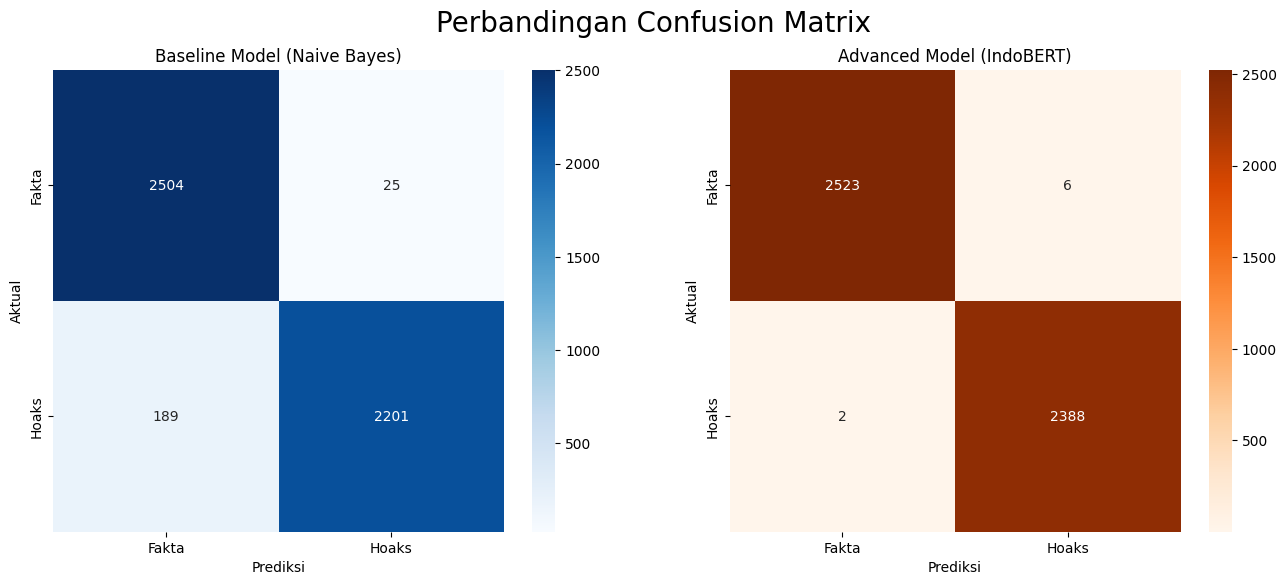

In [9]:
# Visualisasi confusion matrix
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Perbandingan Confusion Matrix', fontsize=20)

cm_baseline = confusion_matrix(y_test, y_pred_baseline)
sns.heatmap(ax=axes[0], data=cm_baseline, annot=True, fmt='d', cmap='Blues')
axes[0].set_title('Baseline Model (Naive Bayes)')
axes[0].set_xlabel('Prediksi'); axes[0].set_ylabel('Aktual')
axes[0].set_xticklabels(['Fakta', 'Hoaks']); axes[0].set_yticklabels(['Fakta', 'Hoaks'])

cm_advanced = confusion_matrix(y_test, y_pred_advanced)
sns.heatmap(ax=axes[1], data=cm_advanced, annot=True, fmt='d', cmap='Oranges')
axes[1].set_title('Advanced Model (IndoBERT)')
axes[1].set_xlabel('Prediksi'); axes[1].set_ylabel('Aktual')
axes[1].set_xticklabels(['Fakta', 'Hoaks']); axes[1].set_yticklabels(['Fakta', 'Hoaks'])

plt.show()

In [10]:
from huggingface_hub import notebook_login

notebook_login()

In [12]:
repo_name = "faris27/indobert-hoax-detection"

print(f"Memulai proses unggah ke Hub: {repo_name}")

# Unggah file model
advanced_model.push_to_hub(repo_name)

# Unggah file tokenizer
tokenizer.push_to_hub(repo_name)

print("Model sudah live di Hugging Face Hub.")
print(f"https://huggingface.co/{repo_name}")

Memulai proses unggah ke Hub: faris27/indobert-hoax-detection


README.md: 0.00B [00:00, ?B/s]

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  /tmp/tmpgfmdc5z9/model.safetensors    :   0%|          |  552kB /  498MB            

No files have been modified since last commit. Skipping to prevent empty commit.


Model sudah live di Hugging Face Hub.
https://huggingface.co/faris27/indobert-hoax-detection
